In [ ]:
!pip install shap

### Random Forest Classification for Sentiment Categories

To predict stock sentiment categories (**Bullish**, **Bearish**, **Neutral**) from post-earnings indicators, a **Random Forest classifier** is trained using features such as **Earnings_Surprise**, **Firm_Size**, and **method_2** sentiment scores. The model is trained on pre-2024 data and evaluated on 2024 data. Classification performance is assessed using **accuracy** and a **detailed classification report** that includes precision, recall, and F1-score for each sentiment class.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the training and test datasets
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

# Define feature columns and target column
feature_columns = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_column = "Category"

X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Define hyperparameter grid 
param_grid = {
    "n_estimators": [100, 300, 500, 700, 900, 1000, 1200, 1500, 1800, 2000],
    "max_depth": [None, 5, 10, 20, 30, 50, 70, 90, 100],
    "min_samples_leaf": [1, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 20, 30, 40]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                      
    scoring='accuracy',        
    n_jobs=-1,                 
    verbose=2                  
)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest Hyperparameters:", grid_search.best_params_)

# Predict using the best estimator
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on Test Set: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] EN

### Feature Importance in Random Forest Classification

To understand the influence of each feature on the model's predictions, feature importances are extracted from the trained **Random Forest classifier**. A horizontal bar chart visualizes the relative importance of **Earnings_Surprise**, **Firm_Size**, and **method_2**, offering insights into which variables most strongly drive the classification of post-earnings sentiment categories.


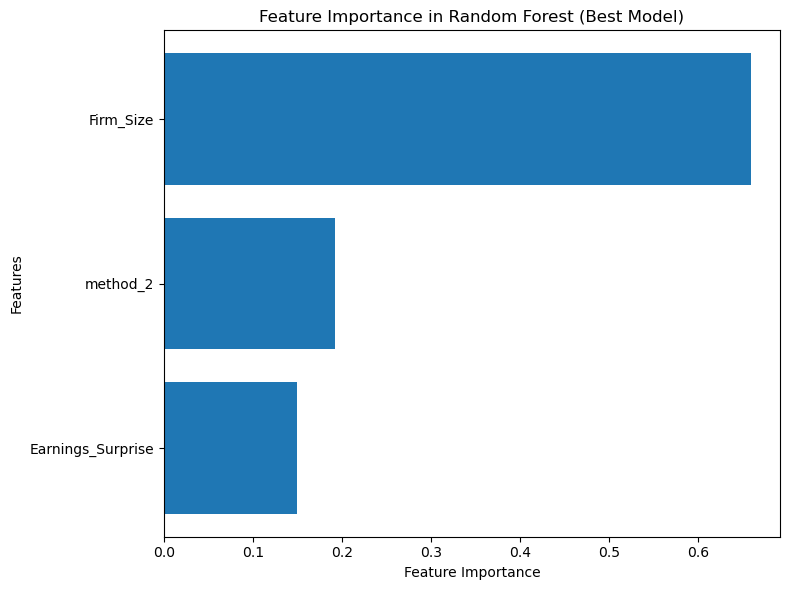

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_rf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_columns)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest (Best Model)")
plt.tight_layout()
plt.show()


### Decision Tree Visualization from Random Forest

To enhance interpretability, a single decision tree from the trained **Random Forest model** is visualized. The plot displays decision rules based on **Earnings_Surprise**, **Firm_Size**, and **method_2**, showing how the model classifies stocks into **Bullish**, **Bearish**, or **Neutral** categories. This visualization provides a transparent view into the logic behind individual tree decisions.


In [16]:
import shap

# Use TreeExplainer with model_output="probability"
explainer = shap.TreeExplainer(best_rf, X_train, model_output="probability")

# Now get SHAP values
shap_values = explainer(X_test)

print("SHAP values shape:", shap_values.shape)
print("Class labels:", best_rf.classes_)


100%|===================| 3792/3795 [06:59<00:00]        

SHAP values shape: (1265, 3, 3)
Class labels: ['Bearish' 'Bullish' 'Neutral']



Class: Bearish


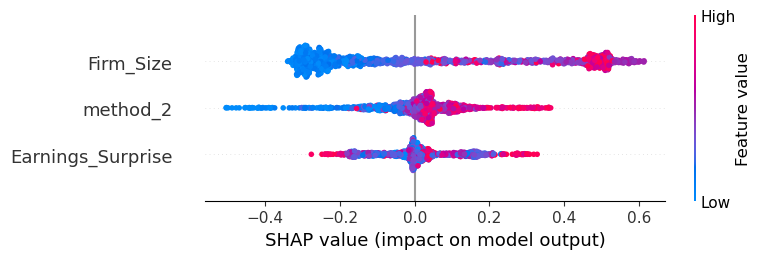


Class: Bullish


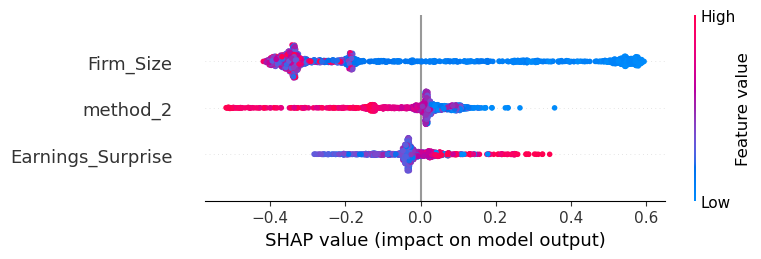


Class: Neutral


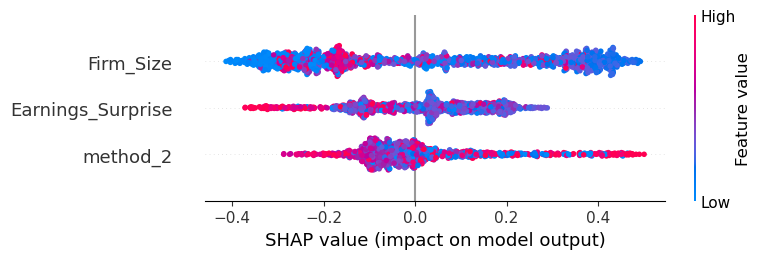

In [17]:
for i, class_name in enumerate(best_rf.classes_):
    print(f"\nClass: {class_name}")
    shap.summary_plot(shap_values[..., i], X_test)


### SHAP Value Computation for Model Explainability

To interpret how each feature influences the Random Forest model’s predictions, **SHAP (SHapley Additive exPlanations)** values are computed using the test set. A SHAP explainer is initialized on the trained model and applied to the test data to generate local explanations for each prediction. These values quantify the contribution of each feature toward the final classification, offering a transparent and model-agnostic way to explain prediction behavior.


In [ ]:
# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Check the output type and structure
print(type(shap_values))
print(f"Number of classes: {len(shap_values)}")
print(f"SHAP values shape for class 0: {shap_values[0].shape}")


<class 'numpy.ndarray'>
Number of classes: 1265
SHAP values shape for class 0: (3, 3)


In [ ]:
import joblib

# Save the best model to a file
joblib.dump(best_rf, "random_forest_best_model.pkl")

print("Model saved successfully!")


Model saved successfully!
